In [13]:
pip install pandas polars pyarrow


Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import polars as pl

# Function to simulate larger datasets by duplicating the data
def create_large_data(scale, original_file='all_stocks_5yr.csv'):
    # Load the original dataset
    df = pd.read_csv(original_file)
    
    # Duplicate the data to simulate larger datasets
    df_large = pd.concat([df] * scale, ignore_index=True)
    
    # Save the scaled dataset
    output_file = f'large_dataset_{scale}x.csv'
    df_large.to_csv(output_file, index=False)
    return output_file

# Create datasets for Scale 1x, 10x, and 100x
for scale in [1, 10, 100]:
    create_large_data(scale)


In [17]:
import time
import os

# Function to benchmark reading and writing times for CSV and Parquet formats
def benchmark_data(scale, file_path):
    # CSV read time (Pandas)
    start_time = time.time()
    df_csv_pandas = pd.read_csv(file_path)
    csv_read_time_pandas = time.time() - start_time

    # Save as Parquet using Pandas
    parquet_file = file_path.replace('.csv', '.parquet')
    df_csv_pandas.to_parquet(parquet_file, compression='snappy')

    # Parquet read time (Pandas)
    start_time = time.time()
    df_parquet_pandas = pd.read_parquet(parquet_file)
    parquet_read_time_pandas = time.time() - start_time

    # CSV read time (Polars)
    start_time = time.time()
    df_csv_polars = pl.read_csv(file_path)
    csv_read_time_polars = time.time() - start_time

    # Save as Parquet using Polars
    df_csv_polars.write_parquet(parquet_file.replace('.csv', '_polars.parquet'), compression='snappy')

    # Parquet read time (Polars)
    start_time = time.time()
    df_parquet_polars = pl.read_parquet(parquet_file.replace('.csv', '_polars.parquet'))
    parquet_read_time_polars = time.time() - start_time

    return {
        'csv_read_time_pandas': csv_read_time_pandas,
        'parquet_read_time_pandas': parquet_read_time_pandas,
        'csv_read_time_polars': csv_read_time_polars,
        'parquet_read_time_polars': parquet_read_time_polars
    }

# Create and benchmark the data at different scales
scales = [1, 10, 100]
for scale in scales:
    print(f"\nBenchmarking for Scale {scale}x:")
    # Create a large dataset for the current scale
    large_file = create_large_data(scale)
    
    # Run benchmarking on the data
    benchmark_results = benchmark_data(scale, large_file)
    
    # Print results
    print(f"Results for {scale}x Scale:")
    print(f"CSV Read Time (Pandas): {benchmark_results['csv_read_time_pandas']:.4f} seconds")
    print(f"Parquet Read Time (Pandas): {benchmark_results['parquet_read_time_pandas']:.4f} seconds")
    print(f"CSV Read Time (Polars): {benchmark_results['csv_read_time_polars']:.4f} seconds")
    print(f"Parquet Read Time (Polars): {benchmark_results['parquet_read_time_polars']:.4f} seconds")

    # Clean up the generated large data file
    os.remove(large_file)



Benchmarking for Scale 1x:
Results for 1x Scale:
CSV Read Time (Pandas): 0.3011 seconds
Parquet Read Time (Pandas): 0.1267 seconds
CSV Read Time (Polars): 0.0326 seconds
Parquet Read Time (Polars): 0.0495 seconds

Benchmarking for Scale 10x:
Results for 10x Scale:
CSV Read Time (Pandas): 2.6557 seconds
Parquet Read Time (Pandas): 0.6018 seconds
CSV Read Time (Polars): 0.2509 seconds
Parquet Read Time (Polars): 0.0836 seconds

Benchmarking for Scale 100x:
Results for 100x Scale:
CSV Read Time (Pandas): 34.6175 seconds
Parquet Read Time (Pandas): 8.2648 seconds
CSV Read Time (Polars): 7.9300 seconds
Parquet Read Time (Polars): 6.4738 seconds


In [17]:
import pandas as pd
import polars as pl
import time

# Load the dataset
csv_file = 'all_stocks_5yr.csv'

# Read data with pandas
df_pandas = pd.read_csv(csv_file)

# Read data with polars
df_polars = pl.read_csv(csv_file)

# 1. Simple Moving Average (SMA)
def calculate_sma(df, window=14):
    df['SMA'] = df['close'].rolling(window=window).mean()
    return df

# 2. Exponential Moving Average (EMA) in Polars (Manual Calculation)
def calculate_ema_polars(df, span=14):
    alpha = 2 / (span + 1)  # Smoothing factor
    ema_values = []
    
    # Initialize with the first value (same as simple moving average)
    ema_values.append(df['close'][0])  # EMA starts as the first close price
    
    for i in range(1, len(df)):
        ema = alpha * df['close'][i] + (1 - alpha) * ema_values[i-1]
        ema_values.append(ema)
    
    # Add the EMA values as a new column
    df = df.with_columns(pl.Series('EMA', ema_values))
    return df

# 3. Relative Strength Index (RSI) in Polars (Fixed)
def calculate_rsi_polars(df, window=14):
    delta = df['close'].diff()
    
    # Gain and Loss calculation using pl.when().then().otherwise()
    gain = pl.when(delta > 0).then(delta).otherwise(0)
    loss = pl.when(delta < 0).then(-delta).otherwise(0)
    
    # Rolling Mean for Gain and Loss
    gain_rolling = gain.rolling_mean(window_size=window)
    loss_rolling = loss.rolling_mean(window_size=window)
    
    # RS Calculation and RSI
    rs = gain_rolling / loss_rolling
    rsi = 100 - (100 / (1 + rs))
    
    # Add the RSI as a new column
    df = df.with_columns(rsi.alias("RSI"))
    
    return df

# 4. Moving Average Convergence Divergence (MACD)
def calculate_macd_polars(df):
    # Calculate EMA for 12-period and 26-period
    ema_12 = calculate_ema_polars(df, span=12)['EMA']
    ema_26 = calculate_ema_polars(df, span=26)['EMA']
    
    # Calculate MACD and Signal lines
    macd_values = [ema_12[i] - ema_26[i] for i in range(len(ema_12))]
    
    # EMA of the MACD for the Signal line
    ema_macd = calculate_ema_polars(df, span=9)['EMA']
    
    # Add the MACD and Signal as new columns
    df = df.with_columns([
        pl.Series("MACD", macd_values),
        pl.Series("Signal", ema_macd)
    ])
    return df

# ---------------------------
# Pandas Approach (Benchmarking)
start_time = time.time()
df_pandas = calculate_sma(df_pandas)
df_pandas = calculate_ema(df_pandas)
df_pandas = calculate_rsi(df_pandas)
df_pandas = calculate_macd(df_pandas)
pandas_time = time.time() - start_time

# ---------------------------
# Polars Approach (Benchmarking)
start_time = time.time()

# Polars doesn't directly support rolling window, so we'll create a custom function for RSI calculation in Polars
# Calculate SMA using Polars
df_polars = df_polars.with_columns([
    pl.col("close").rolling_mean(window_size=14).alias("SMA"),
])

# Custom EMA calculation using the `with_columns` method to add the new column
df_polars = calculate_ema_polars(df_polars, span=14)

# Calculate MACD in Polars (Using custom EMA function)
df_polars = calculate_macd_polars(df_polars)

# Final RSI calculation in Polars (Fixed)
df_polars = calculate_rsi_polars(df_polars)

polars_time = time.time() - start_time

# ---------------------------
# Results and Time Comparison
print("Pandas execution time:", pandas_time, "seconds")
print("Polars execution time:", polars_time, "seconds")

# Show sample outputs for both methods
print("\nPandas sample data:")
print(df_pandas[['date', 'close', 'SMA', 'EMA', 'RSI', 'MACD', 'Signal']].head())

print("\nPolars sample data:")
df_polars.head(5)


Pandas execution time: 0.27811717987060547 seconds
Polars execution time: 8.181116342544556 seconds

Pandas sample data:
         date  close  SMA        EMA  RSI      MACD    Signal
0  2013-02-08  14.75  NaN  14.750000  NaN  0.000000  0.000000
1  2013-02-11  14.46  NaN  14.711333  NaN -0.023134 -0.004627
2  2013-02-12  14.27  NaN  14.652489  NaN -0.056152 -0.014932
3  2013-02-13  14.66  NaN  14.653490  NaN -0.050270 -0.021999
4  2013-02-14  13.99  NaN  14.565025  NaN -0.098535 -0.037307

Polars sample data:


date,open,high,low,close,volume,name,SMA,EMA,MACD,Signal,RSI
str,f64,f64,f64,f64,i64,str,f64,f64,f64,f64,f64
"""2013-02-08""",15.07,15.12,14.63,14.75,8407500,"""AAL""",null,14.75,0.0,14.75,null
"""2013-02-11""",14.89,15.01,14.26,14.46,8882000,"""AAL""",null,14.711333,-0.023134,14.692,null
"""2013-02-12""",14.45,14.51,14.1,14.27,8126000,"""AAL""",null,14.652489,-0.056152,14.6076,null
"""2013-02-13""",14.3,14.94,14.25,14.66,10259500,"""AAL""",null,14.65349,-0.05027,14.61808,null
"""2013-02-14""",14.94,14.96,13.16,13.99,31879900,"""AAL""",null,14.565025,-0.098535,14.492464,null


In [20]:
# Double check the column names after calculating technical indicators
print(df_pandas.columns)


Index(['date', 'open', 'high', 'low', 'close', 'volume', 'name',
       'next_day_close'],
      dtype='object')


In [22]:
import pandas as pd
import numpy as np

# Assuming df_pandas is already loaded
# Step 1: Calculate SMA (14-period)
df_pandas['SMA'] = df_pandas['close'].rolling(window=14).mean()

# Step 2: Calculate EMA (14-period)
df_pandas['EMA'] = df_pandas['close'].ewm(span=14, adjust=False).mean()

# Step 3: Calculate RSI (14-period)
delta = df_pandas['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_pandas['RSI'] = 100 - (100 / (1 + rs))

# Step 4: Calculate MACD (12, 26-period)
df_pandas['EMA12'] = df_pandas['close'].ewm(span=12, adjust=False).mean()
df_pandas['EMA26'] = df_pandas['close'].ewm(span=26, adjust=False).mean()
df_pandas['MACD'] = df_pandas['EMA12'] - df_pandas['EMA26']

# Step 5: Calculate Signal Line (9-period EMA of MACD)
df_pandas['Signal'] = df_pandas['MACD'].ewm(span=9, adjust=False).mean()

# Check the resulting DataFrame columns to confirm the indicators are added
print(df_pandas.columns)


Index(['date', 'open', 'high', 'low', 'close', 'volume', 'name',
       'next_day_close', 'SMA', 'EMA', 'RSI', 'EMA12', 'EMA26', 'MACD',
       'Signal'],
      dtype='object')


In [26]:
# Drop rows with any NaN values in the features or target variable
df_pandas = df_pandas.dropna(subset=features + ['next_day_close'])

# Re-split the data into features and target
X = df_pandas[features]
y = df_pandas['next_day_close']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [28]:
from sklearn.impute import SimpleImputer

# Create an imputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the feature columns
X_imputed = imputer.fit_transform(X)

# Impute missing values in the target column (optional, based on need)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1))

# Re-split the imputed data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, shuffle=False)


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import time

# Assuming df_pandas has been populated with the technical indicators and 'next_day_close'

# Drop rows with any NaN values in the features or target variable
df_pandas = df_pandas.dropna(subset=features + ['next_day_close'])

# Features and Target
features = ['SMA', 'EMA', 'RSI', 'MACD', 'Signal']
X = df_pandas[features]
y = df_pandas['next_day_close']

# Train-Test Split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------------
# Linear Regression Model
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicting on test set
y_pred_lr = lr_model.predict(X_test)

# Model Evaluation
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_time = time.time() - start_time
print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression Time:", lr_time)

# ----------------------------
# Random Forest Model
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on test set
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_time = time.time() - start_time
print("Random Forest RMSE:", rf_rmse)
print("Random Forest Time:", rf_time)

# ---------------------------
# Displaying the comparison of models
print("\nComparison of Models:")
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Linear Regression Time: {lr_time} seconds")
print(f"Random Forest Time: {rf_time} seconds")


Linear Regression RMSE: 2.468949739502846
Linear Regression Time: 0.3210940361022949
Random Forest RMSE: 2.229364180371366
Random Forest Time: 1531.864039182663

Comparison of Models:
Linear Regression RMSE: 2.468949739502846
Random Forest RMSE: 2.229364180371366
Linear Regression Time: 0.3210940361022949 seconds
Random Forest Time: 1531.864039182663 seconds


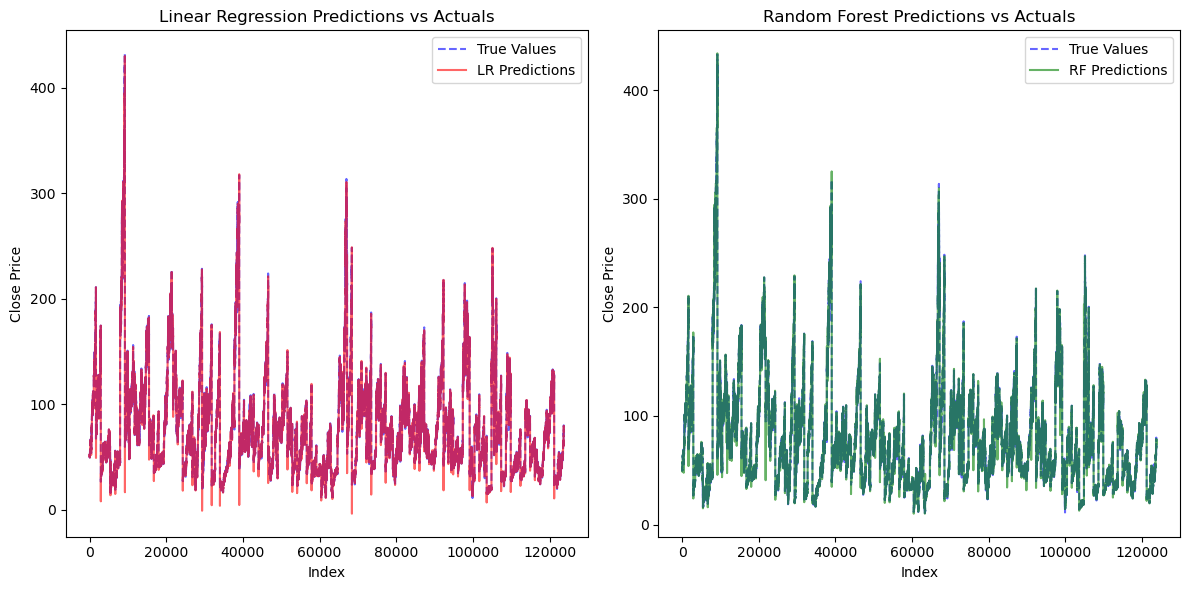

In [32]:
import matplotlib.pyplot as plt

# Plotting Linear Regression predictions vs actual values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test.values, label="True Values", color="blue", linestyle='--', alpha=0.6)
plt.plot(y_pred_lr, label="LR Predictions", color="red", alpha=0.6)
plt.title("Linear Regression Predictions vs Actuals")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()

# Plotting Random Forest predictions vs actual values
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label="True Values", color="blue", linestyle='--', alpha=0.6)
plt.plot(y_pred_rf, label="RF Predictions", color="green", alpha=0.6)
plt.title("Random Forest Predictions vs Actuals")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
from sklearn.metrics import r2_score

# R² score for Linear Regression
lr_r2 = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R²: {lr_r2}")

# R² score for Random Forest
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest R²: {rf_r2}")


Linear Regression R²: 0.9970780757619735
Random Forest R²: 0.9976176449252844


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Setting up the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Defining the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Running GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Retraining the model using the best hyperparameters
best_rf_model = grid_search.best_estimator_

# Predicting using the optimized Random Forest model
y_pred_rf_optimized = best_rf_model.predict(X_test)

# Evaluating the optimized model
from sklearn.metrics import mean_squared_error, r2_score

# RMSE for the optimized model
rmse_rf_optimized = mean_squared_error(y_test, y_pred_rf_optimized, squared=False)
print(f"Optimized Random Forest RMSE: {rmse_rf_optimized}")

# R² score for the optimized model
r2_rf_optimized = r2_score(y_test, y_pred_rf_optimized)
print(f"Optimized Random Forest R²: {r2_rf_optimized}")


In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Random Forest model (using best hyperparameters)
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Mean RMSE from cross-validation scores
mean_cv_rmse = (-cv_scores.mean())**0.5
print(f"Cross-Validation RMSE for Optimized RF: {mean_cv_rmse}")
